# General Information
![](https://static.tacdn.com/img2/brand_refresh/application_icons/post-image-550x370.png)

This was my first experience developing a mathematical model for data prediction, which I received in the Data Science course from SkillFactory. The legend was that we have a TripAdvisor dataset with EU-based restaurants. TA has "dishonest" restaurants which artificially inflate their rating. One way to find scammers is to build a model that predicts the restaurant's rating. If the model's forecasts are vastly different from the actual result, it is possible that the restaurant is not playing fair.

## 1. Initial Setup

In [337]:
# Importing modules.
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns 
import os

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

%matplotlib inline

In [338]:
#Setting the conditions for experiments.
random_seed = 42
current_date = pd.to_datetime('29/08/2020')
!pip freeze > requirements.txt
data_directory = '/kaggle/input/sf-dst-restaurant-rating/'

In [339]:
# Importing datasets.
data_train = pd.read_csv(data_directory+'/main_task.csv')
data_test = pd.read_csv(data_directory+'/kaggle_task.csv')
sample_submission = pd.read_csv(data_directory+'/sample_submission.csv')

In [340]:
# Checkin the dataset for training.
data_train.info()
data_train.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
4894,id_251,Barcelona,"['Latin', 'Mexican', 'Central American', 'Vege...",252.0,4.5,$$ - $$$,663.0,"[['Best taco’s in town', 'Good quality by pric...",/Restaurant_Review-g187497-d2321735-Reviews-Tl...,d2321735
22679,id_5738,Milan,"['Italian', 'Pizza', 'Spanish']",5741.0,3.0,NaN,60.0,"[[], []]",/Restaurant_Review-g187849-d937803-Reviews-Paq...,d937803
24003,id_2880,Brussels,"['Belgian', 'European']",2881.0,3.5,$$ - $$$,5.0,"[['Great chocolate', 'Good chocolate'], ['12/1...",/Restaurant_Review-g188644-d12208932-Reviews-C...,d12208932
26995,id_1281,Lyon,NaN,1282.0,4.5,NaN,8.0,"[[], []]",/Restaurant_Review-g187265-d10290676-Reviews-R...,d10290676
29812,id_606,Hamburg,NaN,607.0,4.5,NaN,22.0,"[['Perfect', 'Really good Italian cuisine in N...",/Restaurant_Review-g187331-d1346217-Reviews-La...,d1346217


In [341]:
# Checkin the dataset for prediction.
data_test.info()
data_test.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
3721,id_3721,Oslo,"['Mexican', 'Fast Food', 'Central American', '...",193.0,$,68.0,[['Loved the beef tacos. Avoid the nachos if.....,/Restaurant_Review-g190479-d7744452-Reviews-4G...,d7744452
7505,id_7505,London,NaN,14172.0,NaN,3.0,"[['Nice Brreakfast Buffet', 'Average ...'], ['...",/Restaurant_Review-g186338-d8509068-Reviews-So...,d8509068
5874,id_5874,Amsterdam,"['Steakhouse', 'Barbecue', 'Argentinean', 'Glu...",1026.0,$$ - $$$,182.0,"[['Great steak', 'Nice meals/drinks and friend...",/Restaurant_Review-g188590-d4301712-Reviews-La...,d4301712
1875,id_1875,Berlin,NaN,3976.0,NaN,6.0,"[['Lovely new Greek restaurant in Berlin'], ['...",/Restaurant_Review-g187323-d10757796-Reviews-R...,d10757796
915,id_915,Barcelona,NaN,5787.0,NaN,2.0,"[[], []]",/Restaurant_Review-g187497-d11957077-Reviews-S...,d11957077


In [342]:
# Checkin the dataset for submission.
sample_submission.info()
sample_submission.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


,Restaurant_id,Rating
9674,id_9674,3.0
4066,id_4066,2.5
6838,id_6838,1.5
4039,id_4039,5.0
9799,id_9799,5.0


Let's merge our databases, but first of all we need to mark our training set as a "Sample" and add "Rating" column to the dataset for prediction.

In [343]:
# Merging the datasets.
data_train['Sample'] = 1
data_test['Sample'] = 0
data_test['Rating'] = 0
data = data_test.append(data_train, sort=False).reset_index(drop=True)

## 2. Examination & Engineering

In [344]:
# Checking the merged data.
data.info()
data.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
Sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Sample,Rating
12995,id_559,Budapest,"['Bar', 'Cafe', 'European', 'Hungarian', 'Inte...",560.0,$,82.0,"[['Quiet location for a snack and a beer', 'Be...",/Restaurant_Review-g274887-d4743871-Reviews-Co...,d4743871,1,4.0
48202,id_11719,Paris,['French'],11721.0,$$ - $$$,62.0,"[['Cost and friendly', 'Nice'], ['12/27/2017',...",/Restaurant_Review-g187147-d11716286-Reviews-C...,d11716286,1,3.5
18130,id_6176,Milan,['Italian'],6180.0,NaN,8.0,"[[], []]",/Restaurant_Review-g187849-d4061572-Reviews-To...,d4061572,1,2.0
41794,id_9089,Paris,['French'],9091.0,$$ - $$$,40.0,"[['Watch the world go by', 'Nice place for a q...",/Restaurant_Review-g187147-d4106127-Reviews-Br...,d4106127,1,4.0
29168,id_1231,Geneva,"['Italian', 'Mediterranean', 'European', 'Vege...",1237.0,$$ - $$$,100.0,"[['It could be better', 'Very good Italian for...",/Restaurant_Review-g188057-d1200541-Reviews-Ca...,d1200541,1,3.0


In [345]:
# Checking the data.
data['Cuisine Style'][1]

"['European', 'Scandinavian', 'Gluten Free Options', 'Vegetarian Friendly', 'Vegan Options']"

In [346]:
# Checking the data.
data['Reviews'][1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

### 2.1 Preliminary Data Analysis

* City - the city where the restaurant is located. We can use this variable as a basis for creating additional features using external sources.
* Cuisine Style - features of the restaurant's cuisine (cuisine of a certain country or nation, vegetarian, etc.). This variable needs to be cleaned.
* Ranking - the restaurant's rank relative to other restaurants in the city. Calculated based on the rating, number and novelty of reviews (https://www.tripadvisor.com/TripAdvisorInsights/w722). If there are 100 restaurants in a city, the worst restaurant will have a rank of 100, and the best one will have a rank of 1. Because of this, the variable value may be duplicated. Perhaps we should check a relative ranking.
* Price Range - price category of the restaurant (cheap, medium, expensive). This feature needs to be converted to digital form.
* Number of Reviews - the total number of reviews for the restaurant. According to the description of the TA rating on the official website, it can affect the stability and representativeness of the rating (target variable).
* Reviews - most recent restaurant reviews and the dates of these reviews. From this variable, we can extract the reviews and dates themselves. The rating in reviews (which we do not have in the dataset) directly affects the rating of the restaurant. Dates can be used as a reference for creating new ones.
* URL_TA - the url of the restaurant on TripAdvisor.
* ID_TA - restaurant id on TripAdvisor.
* Rating - "bubble rating" of the restaurant on TripAdvisor. It is calculated based on the ratings that people put in their reviews of the restaurant. Multiple of 0.5, min = 0.5, max = 5.0 (https://www.tripadvisor.com/TripAdvisorInsights/w810). Since the rating is a multiple of 0.5, we should set an additional function to process our forecast to avoid results that are not multiples of 0.5.

### Important remarks:
* Since the bubble rating is defined as an average of the ratings that visitors put in reviews, special attention should be paid to the reviews.
* The ranking variable is calculated based on the rating, so its affinity with the rating also should be strong.
* The ranking is affected by the novelty of reviews, so the date of the last review should be put as a separate feature.
* Since the ranking depends on the city, it makes sense to create a feature that reflects the relative position of the restaurant.

In [347]:
# Counting unique values.
data.nunique(dropna = False)

Restaurant_id        13094
City                    31
Cuisine Style        10732
Ranking              12975
Price Range              4
Number of Reviews     1574
Reviews              41858
URL_TA               49963
ID_TA                49963
Sample                   2
Rating                  10
dtype: int64

Categorical variables: city, cuisine (not processed), price level, and rating.

Continuous variables: restaurant id, ranking, number of reviews, restaurant id in TA system.

The city and cuisine features are nominal categorical variables, since they don't have any internal order or sequence.

The price level and rating features are ordinal categorical variables. They have a internal sequence - from a cheap restaurant to an expensive one and from a low to a high rating.

In [348]:
# Checking for missing values.
data.isna().sum()

Restaurant_id            0
City                     0
Cuisine Style        11590
Ranking                  0
Price Range          17361
Number of Reviews     3200
Reviews                  2
URL_TA                   0
ID_TA                    0
Sample                   0
Rating                   0
dtype: int64

There are many missing values in the cuisine style, price range, and number of reviews columns. There are a couple of missing values in the Reviews feature, but deleting them leads to problems with submitting the result.

### 2.2 Restaurant_id

In [349]:
# Counting values.
data['Restaurant_id'].value_counts()

id_436      19
id_871      19
id_227      19
id_633      19
id_71       18
            ..
id_4954      1
id_11939     1
id_9045      1
id_14976     1
id_15666     1
Name: Restaurant_id, Length: 13094, dtype: int64

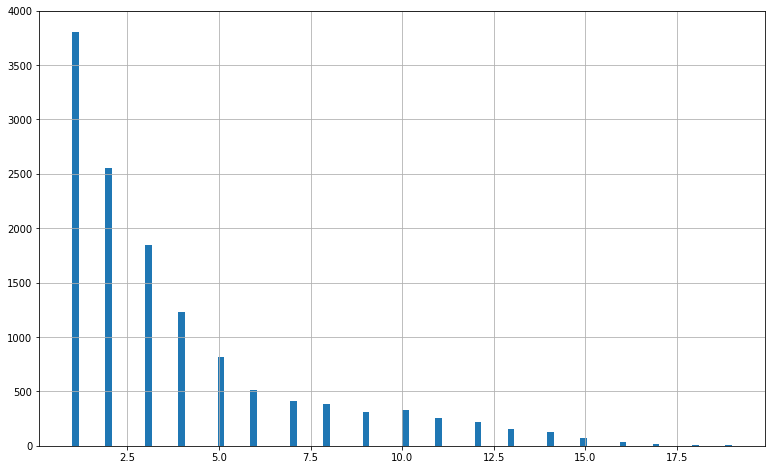

In [350]:
# Checking the frequency distribution.
plt.rcParams['figure.figsize'] = (13,8)
data['Restaurant_id'].value_counts().hist(bins=100)

Significant part of the dataset have a non-unique ID, so the Restaurant_id column has no analytical value and can be deleted.

In [351]:
# Dropping the Restaurant_id column.
data.drop(['Restaurant_id'], inplace = True, axis = 1)

### 2.3 City

In [352]:
# Counting values.
data['City'].value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

In [353]:
#Counting unique cities.
data['City'].nunique()

31

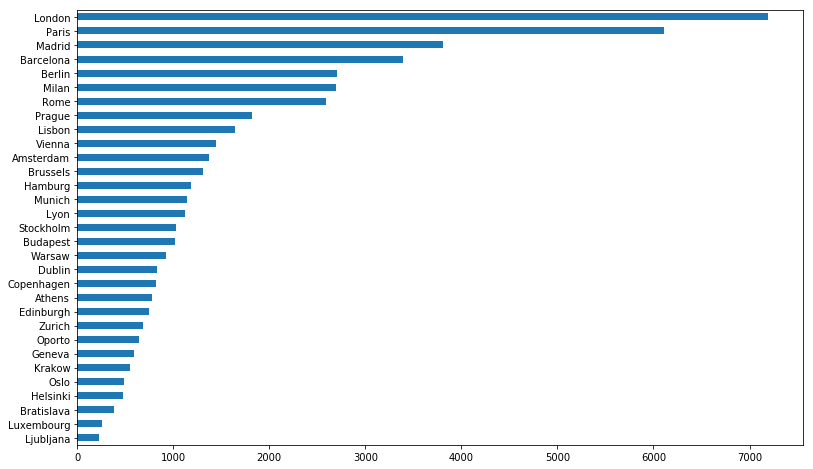

In [354]:
# Checking the frequency distribution.
data['City'].value_counts(ascending=True).plot(kind='barh')

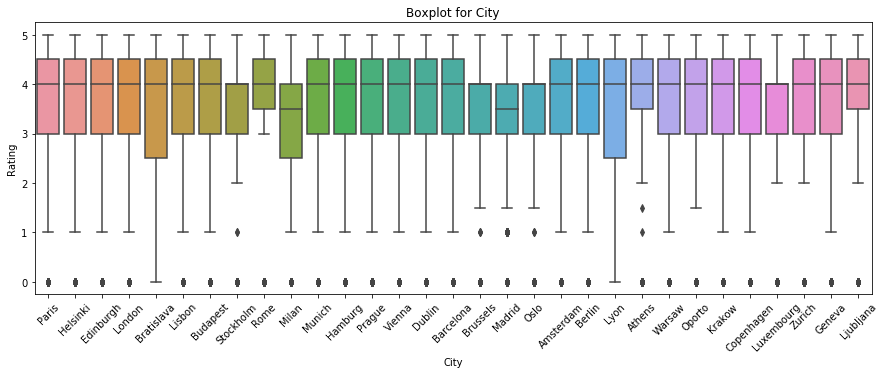

In [355]:
# Checking the Rating distribution by city.
fig, ax = plt.subplots(figsize = (15, 5))

sns.boxplot(x='City', y='Rating',data=data.loc[
    data.loc[:, 'City'].isin(data.loc[:, 'City'].value_counts().index[:])
],ax=ax)

plt.xticks(rotation=45)
ax.set_title('Boxplot for City')

plt.show()

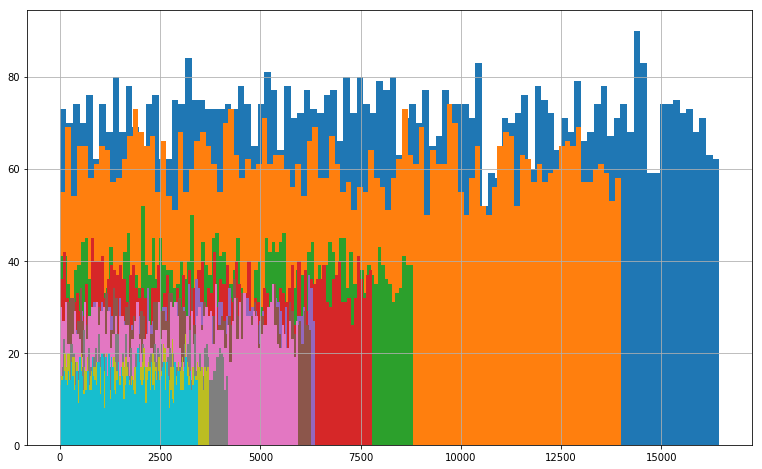

In [356]:
# Checking the Ranking distribution by city.
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100)
plt.show()

It seems that the rating and ranking are proportionally distributed between the cities. Thus, we don't need to split the dataset by city.

Let's add information about the number of restaurants in the each city. We will get this information directly from TripAdvisor.

In [357]:
# Creating dictionary with number of restaurants in the city.
res_count = {
    'Paris': 17593,
    'Stockholm': 3131,
    'London': 22366,
    'Berlin': 8110, 
    'Munich': 3367,
    'Oporto': 2060, 
    'Milan': 7940,
    'Bratislava': 1331,
    'Vienna': 4387, 
    'Rome': 12086,
    'Barcelona': 10086,
    'Madrid': 11562,
    'Dublin': 2706,
    'Brussels': 3703,
    'Zurich': 1901,
    'Warsaw': 3210,
    'Budapest': 3445, 
    'Copenhagen': 2637,
    'Amsterdam': 4189,
    'Lyon': 2833,
    'Hamburg': 3501, 
    'Lisbon': 4985,
    'Prague': 5850,
    'Oslo': 1441, 
    'Helsinki': 1661,
    'Edinburgh': 2248,
    'Geneva': 1753,
    'Ljubljana': 647,
    'Athens': 2814,
    'Luxembourg': 759,
    'Krakow': 1832       
}

In [358]:
# Mapping the dataset with dictionary.
data['Restaurants Count'] = data['City'].map(res_count)
data['Restaurants Count']

0        17593
1         1661
2         2248
3        22366
4         1331
         ...  
49995     7940
49996    17593
49997     3131
49998     3210
49999     7940
Name: Restaurants Count, Length: 50000, dtype: int64

In [359]:
# Converting feature to dummy variables.
data = pd.get_dummies(data, columns=['City',], dummy_na=True)
data.sample(5)

,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Sample,Rating,Restaurants Count,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
30006,"['Austrian', 'European', 'Central European', '...",377.0,$$ - $$$,119.0,"[['A well-above-average Viennese restaurant', ...",/Restaurant_Review-g190454-d946944-Reviews-Mei...,d946944,1,4.5,4387,...,0,0,0,0,0,0,1,0,0,0
20137,"['Lebanese', 'Fast Food', 'Turkish', 'Middle E...",940.0,$,72.0,"[['More than 10 yeas same BEST quality food!',...",/Restaurant_Review-g187323-d1341426-Reviews-Ri...,d1341426,1,4.5,8110,...,0,0,0,0,0,0,0,0,0,0
34529,['Asian'],7828.0,$,20.0,"[['Excellent bubble tea', 'French-quality boba...",/Restaurant_Review-g187147-d3773653-Reviews-Bu...,d3773653,1,4.5,17593,...,0,0,1,0,0,0,0,0,0,0
24207,"['French', 'European']",6223.0,$$$$,87.0,"[['Attention to detail', 'Red berry champagne'...",/Restaurant_Review-g187147-d8765009-Reviews-Le...,d8765009,1,3.5,17593,...,0,0,1,0,0,0,0,0,0,0
24758,NaN,6383.0,NaN,19.0,"[['Charming & down to earth', 'Relaxed Atmosph...",/Restaurant_Review-g187497-d3348649-Reviews-Ca...,d3348649,1,4.0,10086,...,0,0,0,0,0,0,0,0,0,0


### 2.4 Cuisine Style

In [360]:
# Counting values.
data['Cuisine Style'].value_counts()

['Italian']                                                                                                                1332
['French']                                                                                                                 1019
['Spanish']                                                                                                                 860
['French', 'European']                                                                                                      503
['Cafe']                                                                                                                    500
                                                                                                                           ... 
['German', 'Bar', 'European', 'Pub', 'Central European', 'Hungarian']                                                         1
['Delicatessen', 'Italian', 'Mediterranean', 'European', 'Vegetarian Friendly', 'Gluten Free Options', '

Let's record the presence of missing values as a separate binary variable.

In [361]:
# Creating a binary variable for missing values.
data['Cuisine Style NAN'] = pd.isna(data['Cuisine Style']).astype('uint8')

As a temporary measure, let's replace the missing values with 'No Cuisine Provided'.

In [362]:
# Filling the missing values.
data['Cuisine Style'] = data['Cuisine Style'].fillna('no cuisine provided')

Now let's clear the variable and convert it into a series of lists. This way it will be easier for us to extract data and create new features later.

In [363]:
# Lowering the cases.
data['Cuisine Style'] = data['Cuisine Style'].str.lower() 
data['Cuisine Style']

0                                           ['bar', 'pub']
1        ['european', 'scandinavian', 'gluten free opti...
2                                  ['vegetarian friendly']
3        ['italian', 'mediterranean', 'european', 'vege...
4        ['italian', 'mediterranean', 'european', 'seaf...
                               ...                        
49995    ['italian', 'vegetarian friendly', 'vegan opti...
49996    ['french', 'american', 'bar', 'european', 'veg...
49997                                ['japanese', 'sushi']
49998    ['polish', 'european', 'eastern european', 'ce...
49999                                          ['spanish']
Name: Cuisine Style, Length: 50000, dtype: object

In [364]:
# Converting string values to lists.
def cuisines_to_list(string):
    string = string.replace('[', '')
    string = string.replace(']', '')
    string = string.replace("'", '')
    return string.split(', ')

data['Cuisine Style'] = data['Cuisine Style'].apply(cuisines_to_list)

In [365]:
# Checking the value type.
type(data['Cuisine Style'][0])

list

Now let's see how many unique cuisine styles we have for each restaraunt and overall.

In [366]:
# Creating a new feature.
data['Number of Cuisines'] = data['Cuisine Style'].apply(lambda x: len(x))
data['Number of Cuisines'].value_counts()

1     20744
2      7794
3      6638
4      5948
5      4482
6      2611
7      1294
8       363
9        93
10       26
11        4
21        1
15        1
13        1
Name: Number of Cuisines, dtype: int64

In [367]:
# Creating a set of unique cuisine styles.
cuisines_set = set()

for restaraunt_cuisines in data['Cuisine Style']:
    for cuisine in restaraunt_cuisines:
        cuisines_set.add(cuisine)
        
len(cuisines_set)

126

Let's find out how common each of the styles is in our dataset.

In [368]:
# Counting cuisine styles.
cuisines_counter = dict.fromkeys(cuisines_set, 0)

for cuisine in cuisines_set:
    for restaraunt_cuisines in data['Cuisine Style']:
        if cuisine in restaraunt_cuisines:
            cuisines_counter[cuisine] += 1
            
cuisines_counter = pd.Series(cuisines_counter)
cuisines_counter.sort_values(ascending=False)[0:20]

vegetarian friendly    14021
european               12561
no cuisine provided    11590
mediterranean           7820
italian                 7433
vegan options           5684
gluten free options     5185
bar                     4094
french                  3970
asian                   3786
pizza                   3502
spanish                 3456
pub                     3058
cafe                    2883
fast food               2122
british                 1992
international           1966
seafood                 1878
japanese                1860
central european        1727
dtype: int64

Finally, we will use dummy variables to encode cuisine styles.

In [369]:
# Converting a feature to dummy variables.
data_cuisines = pd.get_dummies(data['Cuisine Style'].apply(pd.Series).stack()).sum(level=0)
data = pd.merge(data, data_cuisines, left_index=True, right_index=True)
data.sample(5)

,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Sample,Rating,Restaurants Count,...,ukrainian,uzbek,vegan options,vegetarian friendly,venezuelan,vietnamese,welsh,wine bar,xinjiang,yunnan
2905,[no cuisine provided],1786.0,NaN,NaN,"[[], []]",/Restaurant_Review-g189541-d12334550-Reviews-R...,d12334550,0,0.0,2637,...,0,0,0,0,0,0,0,0,0,0
27672,[no cuisine provided],4751.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187514-d991184-Reviews-Kul...,d991184,1,4.5,11562,...,0,0,0,0,0,0,0,0,0,0
48061,[italian],5094.0,$,84.0,"[['Very good'], ['01/06/2017']]",/Restaurant_Review-g187791-d4699848-Reviews-La...,d4699848,1,4.0,12086,...,0,0,0,0,0,0,0,0,0,0
14629,"[seafood, mediterranean, european, spanish, po...",8.0,$$ - $$$,764.0,"[['The best meal I had in Hamburg!', '""Mi cass...",/Restaurant_Review-g187331-d7171165-Reviews-Ca...,d7171165,1,4.5,3501,...,0,0,0,1,0,0,0,0,0,0
34889,"[italian, pizza]",1680.0,$,134.0,"[['Better than expected.', 'Desperate, late ni...",/Restaurant_Review-g186525-d2258044-Reviews-Pi...,d2258044,1,2.5,2248,...,0,0,0,0,0,0,0,0,0,0


### 2.5 Ranking

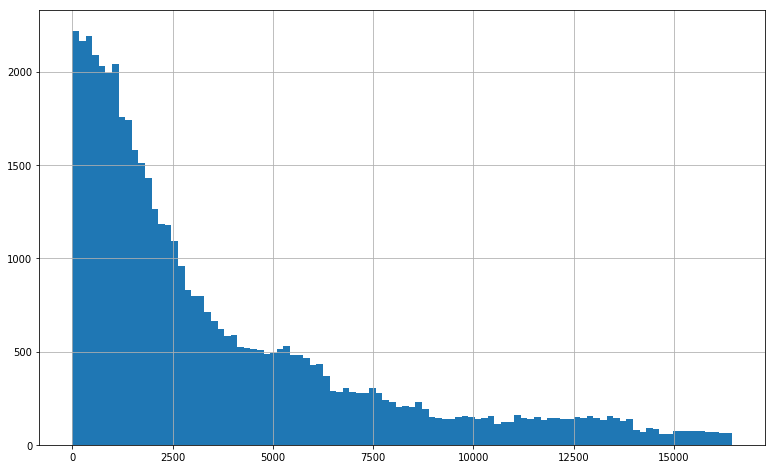

In [370]:
# Checking the Ranking distribution.
data['Ranking'].hist(bins=100)

As mentioned above, the rating depends on the city, so it makes sense to create a feature that reflects the relative position of the restaurant.

In [371]:
# Creating a new feature.
data['Relative Ranking'] = data['Ranking'] / data['Restaurants Count']
data['Relative Ranking']

0        0.736827
1        0.063817
2        0.360320
3        0.074622
4        0.027799
           ...   
49995    0.062972
49996    0.360427
49997    0.527627
49998    0.199688
49999    0.607935
Name: Relative Ranking, Length: 50000, dtype: float64

### 2.6 Price Range

In [372]:
# Counting values.
data['Price Range'].value_counts(dropna=False)

$$ - $$$    23041
NaN         17361
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [373]:
# Creating a binary variable for missing values.
data['Price Range NAN'] = pd.isna(data['Price Range']).astype('uint8')

In [374]:
# Checking the URLs of restaraunts with no price range.
data.query('`Price Range NAN` == 1')['URL_TA'].tolist()[0:11]

['/Restaurant_Review-g274887-d8286886-Reviews-Beer_N_Scooter-Budapest_Central_Hungary.html',
 '/Restaurant_Review-g189934-d12947542-Reviews-Bistro_Gimis-Helsinki_Uusimaa.html',
 '/Restaurant_Review-g189852-d12716384-Reviews-Il_Molo-Stockholm.html',
 '/Restaurant_Review-g187791-d7818546-Reviews-Jerry_Thomas_Speakeasy-Rome_Lazio.html',
 '/Restaurant_Review-g187331-d1344523-Reviews-Il_Cammino-Hamburg.html',
 '/Restaurant_Review-g190454-d8435085-Reviews-Angkor_Club-Vienna.html',
 '/Restaurant_Review-g187497-d8334752-Reviews-Restaurante_Laumon-Barcelona_Catalonia.html',
 '/Restaurant_Review-g187514-d13202032-Reviews-Wan-Madrid.html',
 '/Restaurant_Review-g187497-d5795143-Reviews-La_Bona_Taula_de_Llica-Barcelona_Catalonia.html',
 '/Restaurant_Review-g187147-d11953078-Reviews-Bistrot_Wattignies-Paris_Ile_de_France.html',
 '/Restaurant_Review-g186338-d13234520-Reviews-The_Granary_Brasserie-London_England.html']

After a quick look at the data, we see a lot of average-priced restaurants. Let's assume that this is the case and replace the missing values with the average price category. If our assumption is incorrect, we can always replace the data using the Price Range NAN column.

In [375]:
# Filling the missing values.
data['Price Range'] = data['Price Range'].fillna('$$ - $$$')

In [376]:
# Replacing the object values with numeric values
price_transform_dict = {'$':1,'$$ - $$$':2,'$$$$':3}
data['Price Range'] = data['Price Range'].map(lambda x: price_transform_dict.get(x,x))

data['Price Range'].value_counts()

2    40402
1     7816
3     1782
Name: Price Range, dtype: int64

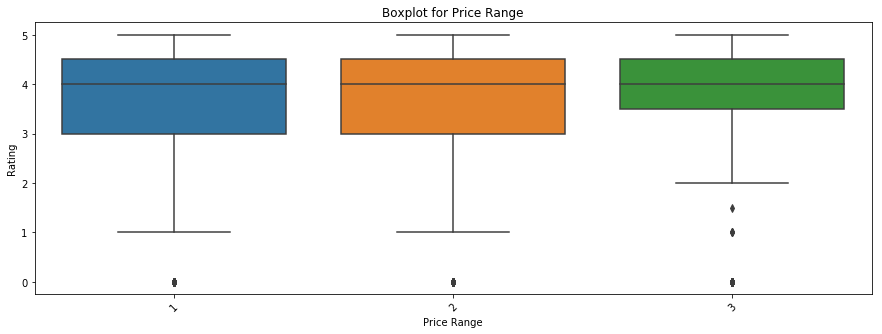

In [377]:
# Checking the Rating distribution by price range.
fig, ax = plt.subplots(figsize = (15, 5))

sns.boxplot(x='Price Range', y='Rating',data=data.loc[
    data.loc[:, 'Price Range'].isin(data.loc[:, 'Price Range'].value_counts().index[:])
],ax=ax)

plt.xticks(rotation=45)
ax.set_title('Boxplot for Price Range')

plt.show()

It seems that rating has no effect on price category. The medians of all price categories are the same, but expensive restaurants have less amount of bad ratings. This may be a psychological distortion of visitors perception.

### 2.7 Number of Reviews

In [378]:
# Counting values.
data['Number of Reviews'].value_counts(dropna=False)

NaN       3200
2.0       2403
3.0       2042
4.0       1707
5.0       1471
          ... 
5216.0       1
1932.0       1
1050.0       1
1145.0       1
1471.0       1
Name: Number of Reviews, Length: 1574, dtype: int64

In [379]:
# Creating a binary variable for missing values.
data['Number of Reviews NAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

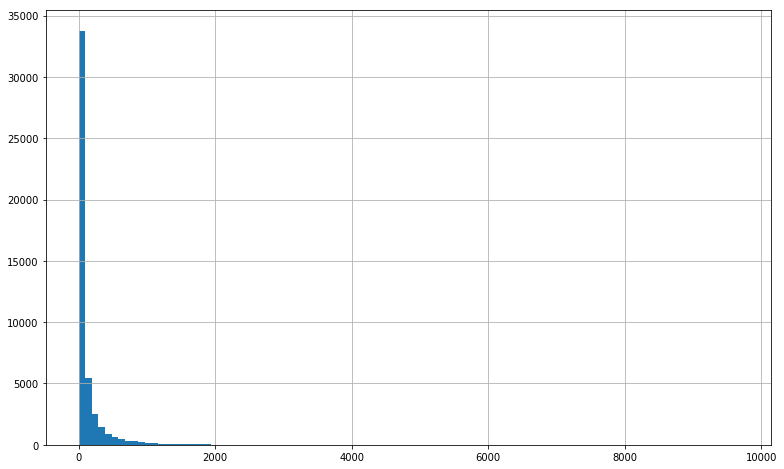

In [380]:
# Checking the frequency distribution.
data['Number of Reviews'].hist(bins=100)

Let's try to go deeper into the data on the number of reviews, using the link to the restaurant's page.

In [381]:
# Checking the URLs of restaraunts with no number of reviews.
data.query('`Number of Reviews NAN` == 1')['URL_TA'].tolist()[0:11]

['/Restaurant_Review-g274887-d8286886-Reviews-Beer_N_Scooter-Budapest_Central_Hungary.html',
 '/Restaurant_Review-g187514-d13202032-Reviews-Wan-Madrid.html',
 '/Restaurant_Review-g274707-d7124128-Reviews-Chocobamba-Prague_Bohemia.html',
 '/Restaurant_Review-g274707-d12032989-Reviews-Cafe_Nova_doba-Prague_Bohemia.html',
 '/Restaurant_Review-g187497-d10088997-Reviews-Nasca-Barcelona_Catalonia.html',
 '/Restaurant_Review-g1166685-d12644341-Reviews-Otentik_City-Saint_Priest_Lyon_Rhone_Auvergne_Rhone_Alpes.html',
 '/Restaurant_Review-g187497-d12204689-Reviews-Sant_Tomassino_Gracia-Barcelona_Catalonia.html',
 '/Restaurant_Review-g187323-d4802788-Reviews-Boccato_DI_Cardina-Berlin.html',
 '/Restaurant_Review-g187497-d12530776-Reviews-Casa_NOVA-Barcelona_Catalonia.html',
 '/Restaurant_Review-g188590-d753088-Reviews-Banco_Solo-Amsterdam_North_Holland_Province.html',
 '/Restaurant_Review-g274887-d12953643-Reviews-Egyetem_Restaurant-Budapest_Central_Hungary.html']

After browsing the links, it becomes clear that a visible part of them are little-known or brand new restaurants. Let's assume that at the time of collecting the dataset, these restaurants did not have reviews and fill in the gaps in this column with zeros.

In [382]:
# Filling the missing values.
data['Number of Reviews'] = data['Number of Reviews'].fillna(0)

In [383]:
# Creating a new feature.
data['Reviews to Ranking Ratio'] = data['Number of Reviews'] / data['Ranking']
data['Reviews to Ranking Ratio']

0        0.000309
1        0.915094
2        0.034568
3        0.121031
4        4.378378
           ...   
49995    0.158000
49996    0.085475
49997    0.002421
49998    0.109204
49999    0.053864
Name: Reviews to Ranking Ratio, Length: 50000, dtype: float64

### 2.8 Reviews

In [384]:
# Checking the data.
data['Reviews'].head(20)

0                                              [[], []]
1     [['Very good reviews!', 'Fine dining in Hakani...
2     [['Better than the Links', 'Ivy Black'], ['12/...
3     [['Most exquisite', 'Delicious and authentic']...
4     [['Always the best in bratislava', 'Very good ...
5     [['Lunch Break', 'Good to Quick Bite'], ['09/0...
6                                              [[], []]
7                                              [[], []]
8     [['Big group supper', 'Good food but very slow...
9     [['Good food', 'Good pizza'], ['12/02/2017', '...
10    [['Very pretentious, but drinks are top notch'...
11    [['GREAT APERITIVO WITH STYLE', 'Disappointing...
12    [['You always feel very Welcome at this cozy.....
13    [['Surprisingly good pizza', 'Yummy'], ['09/28...
14    [['Good food, beer, value and service', 'Eat u...
15    [['Very nice food and staff', 'Lovely service ...
16    [['truly Neapolitan pizza, new/slick location'...
17    [['Quite a decent pub', 'in the middle of 

In [385]:
# Filling the missing values.
data['Reviews'] = data['Reviews'].fillna('[[], []]')

In [386]:
# Extracting the lists with dates of reviews.
def reviews_to_dates_list(string):
    if string == '[[], []]':
        return []
    else:
        string = string.replace(']]', '')
        string = string.replace("'", '')
        string = string.split('], [')[1]
        string = string.split(', ')
        return string
    
data['Dates of Reviews'] = data['Reviews'].apply(reviews_to_dates_list)

In [387]:
# Checking the data.
data['Dates of Reviews'].head(20)

0                           []
1     [12/05/2017, 10/29/2017]
2     [12/28/2017, 12/06/2017]
3     [12/06/2017, 11/22/2017]
4     [02/08/2018, 01/24/2018]
5     [09/07/2017, 09/02/2017]
6                           []
7                           []
8     [01/07/2018, 10/11/2017]
9     [12/02/2017, 10/29/2017]
10    [09/11/2017, 06/25/2017]
11    [05/16/2015, 02/22/2015]
12                [03/20/2010]
13    [09/28/2017, 09/19/2016]
14    [04/18/2017, 03/01/2017]
15    [01/01/2017, 11/12/2016]
16    [06/21/2017, 03/23/2017]
17    [12/28/2017, 12/12/2017]
18                          []
19    [08/24/2017, 07/20/2017]
Name: Dates of Reviews, dtype: object

In [388]:
# Splitting the dates of reviews.
data[['Latest Review Date','Pre-Latest Review Date']] = pd.DataFrame(
    data['Dates of Reviews'].tolist(), index= data.index)

In [389]:
# Converting values to datetime.
data['Latest Review Date'] = pd.to_datetime(data['Latest Review Date'])
data['Pre-Latest Review Date'] = pd.to_datetime(data['Pre-Latest Review Date'])

In [390]:
# Creating a binary variables for missing values.
data['Latest Review Date NAN'] = pd.isna(data['Latest Review Date']).astype('uint8')
data['Pre-Latest Review Date NAN'] = pd.isna(data['Pre-Latest Review Date']).astype('uint8')

Let's think about how to fill in the missing values. The best approximation is to convert datetime to numeric form and then fill in the missing values with zeros.

In [391]:
# Converting the features to float.
data['Latest Review Date'] = pd.to_timedelta(
    data['Latest Review Date']).dt.total_seconds()
data['Pre-Latest Review Date'] = pd.to_timedelta(
    data['Pre-Latest Review Date']).dt.total_seconds()

/opt/conda/lib/python3.6/site-packages/pandas/util/_decorators.py:208: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  return func(*args, **kwargs)


In [392]:
# Filling the missing values.
data['Latest Review Date'] = data['Latest Review Date'].fillna(0)
data['Pre-Latest Review Date'] = data['Pre-Latest Review Date'].fillna(0)

In [393]:
# Creating a new feature.
data['Timedelta for Reviews'] = data['Latest Review Date'] - data['Pre-Latest Review Date']
data['Timedelta for Reviews'].value_counts().sort_index()

-3.127680e+07    1
-3.093120e+07    1
-3.058560e+07    2
-3.041280e+07    1
-3.024000e+07    3
                ..
 1.518998e+09    1
 1.519085e+09    1
 1.519171e+09    1
 1.519258e+09    1
 1.519344e+09    1
Name: Timedelta for Reviews, Length: 3347, dtype: int64

In [394]:
# Creating a new feature.
current_date_float = pd.to_timedelta(pd.Series(current_date)).dt.total_seconds()[0]
data['Timedelta Today - Last Review'] = current_date_float - data['Latest Review Date']
data['Timedelta Today - Last Review']

0        1.598659e+09
1        8.622720e+07
2        8.424000e+07
3        8.614080e+07
4        8.061120e+07
             ...     
49995    8.527680e+07
49996    8.484480e+07
49997    1.205280e+08
49998    9.892800e+07
49999    1.444608e+08
Name: Timedelta Today - Last Review, Length: 50000, dtype: float64

In [395]:
# Cleaning data to get content of latests reviews.
def reviews_to_latest_review(string):
    if string == '[[], []]':
        return float ('NaN')
    else:
        string = string.replace(']]', '')
        string = string.replace("'", '')
        string = string.split('], [')[0]
        string = string.replace('[[', '')
        string = string.split(', ')[0]
        return string

data['Latest Review Content'] = data['Reviews'].apply(reviews_to_latest_review)
data['Latest Review Content']

0                                  NaN
1                   Very good reviews!
2                Better than the Links
3                       Most exquisite
4        Always the best in bratislava
                     ...              
49995     The real Italian experience!
49996              Parisian atmosphere
49997        Good by swedish standards
49998           Underground restaurant
49999                          Average
Name: Latest Review Content, Length: 50000, dtype: object

In [396]:
# Cleaning data to get content of pre-latests reviews.
def reviews_to_pre_latest_review(string):
    if string == '[[], []]':
        return float ('NaN')
    else:
        string = string.replace(']]', '')
        string = string.replace("'", '')
        string = string.split('], [')[0]
        string = string.replace('[[', '')
        string = string.split(', ')[-1]
        return string
    
data['Pre-Latest Review Content'] = data['Reviews'].apply(reviews_to_pre_latest_review)
data['Pre-Latest Review Content']

0                                                  NaN
1                             Fine dining in Hakaniemi
2                                            Ivy Black
3                              Delicious and authentic
4                                 Very good but pricey
                             ...                      
49995                             wonderful experience
49996     Bit pricey but interesting decor and good...
49997    A hidden jewel in the middle of Västertorp...
49998                      Oldest Restaurant in Warsaw
49999                                 Nice an informal
Name: Pre-Latest Review Content, Length: 50000, dtype: object

In [397]:
# Creating a binary variables for missing values.
data['Latest Review Content NAN'] = pd.isna(data['Latest Review Content']).astype('uint8')
data['Pre-Latest Review Content NAN'] = pd.isna(data['Pre-Latest Review Content']).astype('uint8')

In [398]:
# Filling the missing values.
data['Latest Review Content'] = data['Latest Review Content'].fillna('no review provided')
data['Pre-Latest Review Content'] = data['Pre-Latest Review Content'].fillna('no review provided')

To perform semantic evaluation of reviews, we need a reference points. Let's use our data to create lists of good and bad words.

In [399]:
# Lowering the cases.
data['Latest Review Content'] = data['Latest Review Content'].str.lower() 
data['Pre-Latest Review Content'] = data['Pre-Latest Review Content'].str.lower()

In [400]:
# Checking the data.
pd.set_option('display.min_rows', 200)
pd.DataFrame(data['Latest Review Content'].str.split().tolist()).stack().value_counts().head(200)

no               8295
review           8137
provided         8114
food             5791
good             5726
great            5022
and              4527
a                4148
in               3148
the              3003
nice             2923
place            2464
for              2456
very             2049
restaurant       1755
best             1619
excellent        1486
service          1460
to               1445
of               1329
lunch            1326
with             1297
delicious         973
but               960
lovely            914
not               902
pizza             825
dinner            772
friendly          764
tasty             761
                 ... 
surprise          129
late              127
pasta             127
terrible          127
interesting       126
here              126
old               125
are               125
bit               124
fine              124
top               122
nothing           122
disappointing     120
hotel             119
friends   

In [401]:
# Checking the data.
pd.DataFrame(data['Pre-Latest Review Content'].str.split().tolist()).stack().value_counts().head(200)

no              8301
review          8140
provided        8114
food            5147
good            5116
and             5014
great           4890
a               4161
in              3309
the             3252
nice            2510
for             2416
place           2245
very            2084
service         1893
best            1788
restaurant      1615
excellent       1555
to              1451
of              1409
with            1299
lunch           1280
but             1254
not             1071
delicious        898
amazing          815
friendly         806
lovely           785
pizza            754
dinner           722
                ... 
fabulous         131
near             130
slow             128
typical          128
neighborhood     127
hotel            127
day              125
old              123
town             123
top              123
are              123
special          123
off              121
that             121
service!         120
healthy          120
london       

In [402]:
# Establishing lists of words.
good_words_list = [
    'great', 'good', 'nice', 'best', 'excellent', 'delicious', 
    'lovely', 'friendly', 'tasty', 'amazing', 'fantastic', 
    'perfect', 'wonderful', 'gem', 'fresh', 'decent', 'cozy', 
    'pleasant', 'love', 'awesome', 'beautiful', 'yummy', 
    'fabulous', 'superb', 'fine', 'brilliant', 'cute', 'super' 
    'favourite', 'enjoyable', 'favorite', 'outstanding', 
    'pretty', 'affordable', 'charming', 'delightful', 
    'unique', 'incredible', 'solid', 'exceptional'
]

bad_words_list = [
    'bad', 'poor', 'worst', 'terrible', 'disappointing', 
    'overpriced', 'rude', 'avoid', 'awful', 'disappointed', 
    'horrible', 'mediocre', 'cold'
]

Let's use our lists to go through all the reviews. If we find a "good" or "bad" word, we will add the row number to the corresponding set.

In [403]:
# Semantic analysis.
latest_good_set = set()
latest_bad_set = set()
pre_latest_good_set = set()
pre_latest_bad_set = set()

for review in data['Latest Review Content']:
    for word in good_words_list:
        if word in review:
            latest_good_set.add(data[data['Latest Review Content'] == review].index[0])
    for word in bad_words_list:
        if word in review:
            latest_bad_set.add(data[data['Latest Review Content'] == review].index[0])  

for review in data['Pre-Latest Review Content']:
    for word in good_words_list:
        if word in review:
            pre_latest_good_set.add(data[data['Pre-Latest Review Content'] == review].index[0]) 
    for word in bad_words_list:
        if word in review:
            pre_latest_bad_set.add(data[data['Pre-Latest Review Content'] == review].index[0])            

In [404]:
# Creating columns for semantic binary variables.
data['Latest Review Good'] = 0
data['Pre-Latest Review Good'] = 0
data['Latest Review Bad'] = 0
data['Pre-Latest Review Bad'] = 0

In [405]:
# Filling semantic binary variables.
for value in latest_good_set:
    data ['Latest Review Good'][value] = 1

for value in pre_latest_good_set:
    data ['Pre-Latest Review Good'][value] = 1    

for value in latest_bad_set:
    data ['Latest Review Bad'][value] = 1

for value in pre_latest_bad_set:
    data ['Pre-Latest Review Bad'][value] = 1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt

### 2.9 URL_TA

In [406]:
# Checking the data.
data['URL_TA'][1]

'/Restaurant_Review-g189934-d6674944-Reviews-Ravintola_Kolmon3n-Helsinki_Uusimaa.html'

I tried using hyperlinks for parsing, but TripAdvisor's CSS structure was too complex for me to understand, so I decided to just delete this column.

In [407]:
# Dropping the URL_TA column.
data.drop(['URL_TA'], inplace = True, axis = 1)

### 2.10 ID_TA

In [408]:
# Counting values.
pd.set_option('display.min_rows', 10)
data['ID_TA'].value_counts()

d3396817     2
d10440367    2
d8753348     2
d11674463    2
d1235635     2
            ..
d3735885     1
d3396697     1
d786640      1
d4471858     1
d719703      1
Name: ID_TA, Length: 49963, dtype: int64

Some IDs are duplicated, which is strange. Let's try to figure it out.

In [409]:
# Checking the data.
data[data['ID_TA'] == 'd4600226']

,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,ID_TA,Sample,Rating,Restaurants Count,City_Amsterdam,...,Timedelta for Reviews,Timedelta Today - Last Review,Latest Review Content,Pre-Latest Review Content,Latest Review Content NAN,Pre-Latest Review Content NAN,Latest Review Good,Pre-Latest Review Good,Latest Review Bad,Pre-Latest Review Bad
10147,[spanish],4112.0,2,2.0,"[[], []]",d4600226,1,5.0,11562,0,...,0.0,1.598659e+09,no review provided,no review provided,1,1,0,0,0,0
19446,[spanish],4106.0,2,2.0,"[[], []]",d4600226,1,5.0,11562,0,...,0.0,1.598659e+09,no review provided,no review provided,1,1,0,0,0,0


It looks like we're dealing with duplicates. Let's estimate how many of them there are.

In [410]:
# Counting duplicates.
data['ID_TA'].duplicated().value_counts()

False    49963
True        37
Name: ID_TA, dtype: int64

There are a couple of missing values in the Reviews feature, but deleting them leads to problems with submitting the result.

### 2.11 Rating

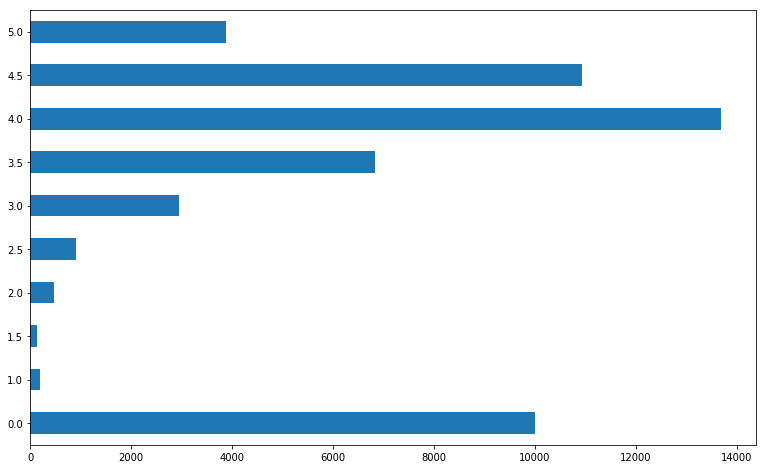

In [411]:
# Checking the frequency distribution.
plt.rcParams['figure.figsize'] = (13,8)
data['Rating'].value_counts(ascending=True).sort_index().plot(kind='barh')

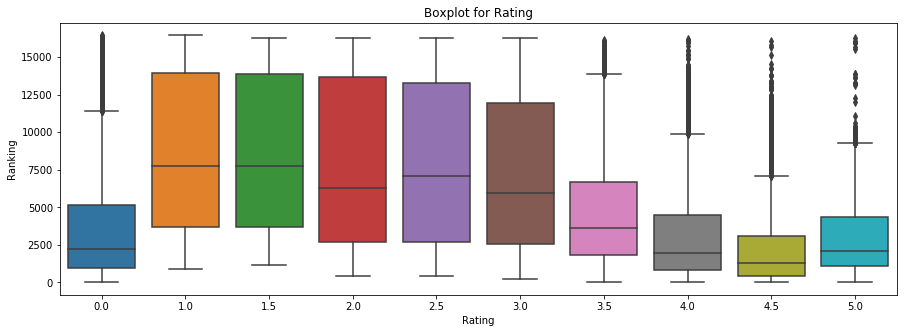

In [412]:
# Checking the Ranking distribution by rating.
fig, ax = plt.subplots(figsize = (15, 5))
sns.boxplot(x = 'Rating', 
            y = 'Ranking', 
            data = data.loc[data.loc[:, 'Rating'].isin(
                data.loc[:, 'Rating'].value_counts().index[:]
            )],ax=ax)
ax.set_title('Boxplot for Rating')
plt.show()

According to this chart, restaurants with a high rating (4+) are usually located in the first 5000 ranking places. Another interesting detail that position and shape of the testing dataset is close to the boxplots of 3.5-4 rating. Thus, we can assume that this rating will be observed on average in the testing dataset.

In [413]:
# Using the correlation matrix (in absolute value).
data.corr().abs().sort_values(by='Rating', ascending=False)

,Ranking,Price Range,Number of Reviews,Sample,Rating,Restaurants Count,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,...,Latest Review Date NAN,Pre-Latest Review Date NAN,Timedelta for Reviews,Timedelta Today - Last Review,Latest Review Content NAN,Pre-Latest Review Content NAN,Latest Review Good,Pre-Latest Review Good,Latest Review Bad,Pre-Latest Review Bad
Rating,0.109897,0.012176,0.011006,0.936543,1.000000,0.010491,0.007447,0.016852,0.000703,0.012834,...,0.010309,0.005352,0.004592,0.011976,0.010309,0.010309,0.003579,0.009204,0.057212,0.057416
Sample,0.006271,0.003419,0.002688,1.000000,0.936543,0.004760,0.003550,0.002912,0.003577,0.001989,...,0.002739,0.000917,0.001930,0.002937,0.002739,0.002739,0.046503,0.050822,0.010460,0.009866
Relative Ranking,0.563339,0.030125,0.408941,0.001157,0.174617,0.021524,0.003888,0.035259,0.011976,0.028771,...,0.298053,0.392472,0.209756,0.316130,0.298053,0.298053,0.188466,0.184880,0.118740,0.115804
Ranking,1.000000,0.026334,0.223198,0.006271,0.109897,0.701203,0.094100,0.094479,0.015683,0.026436,...,0.107399,0.149682,0.087645,0.116869,0.107399,0.107399,0.099661,0.096980,0.085377,0.079552
Pre-Latest Review Bad,0.079552,0.001167,0.022792,0.009866,0.057416,0.008347,0.006986,0.008527,0.001775,0.010627,...,0.072391,0.052344,0.010828,0.070520,0.072391,0.072391,0.012309,0.069412,0.178602,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gastropub,0.019178,0.017492,0.020698,0.007026,0.000290,0.028089,0.007466,0.005073,0.006734,0.020887,...,0.021611,0.030104,0.017730,0.022997,0.021611,0.021611,0.004409,0.007557,0.004609,0.005714
grill,0.013882,0.007080,0.021886,0.001630,0.000209,0.001763,0.024474,0.012347,0.008565,0.000497,...,0.019716,0.030488,0.020074,0.021180,0.019716,0.019716,0.000146,0.008595,0.001546,0.003679
polynesian,0.004949,0.009320,0.001436,0.003162,0.000206,0.006527,0.001062,0.000794,0.001707,0.001513,...,0.005793,0.003171,0.002374,0.005718,0.005793,0.005793,0.004586,0.002026,0.000920,0.001040
City_Lisbon,0.089639,0.025073,0.001748,0.004931,0.000081,0.127936,0.031001,0.023173,0.049813,0.044138,...,0.010113,0.002100,0.009000,0.011040,0.010113,0.010113,0.004585,0.008394,0.000688,0.000432


The correlation matrix tells us that the most strongly associated features with the rating are relative ranking, bad reviews content and number of cuisines.

## 3. Finalizing

### 3.1 Dropping non-numerical data 

In [414]:
# Checking the data.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 188 entries, Cuisine Style to Pre-Latest Review Bad
dtypes: float64(9), int64(8), object(6), uint8(165)
memory usage: 16.6+ MB


In [415]:
# Dropping object columns.
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [416]:
# Checking the data.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 182 entries, Ranking to Pre-Latest Review Bad
dtypes: float64(9), int64(8), uint8(165)
memory usage: 14.4 MB


### 3.2 Normalisation

In [417]:
# Normalizing data (except target variable).
# data_no_rating = data.loc[:, data.columns != 'Rating']

# data_no_rating[data_no_rating.columns] = pd.DataFrame(
#     min_max_scaler.fit_transform(data_no_rating[data_no_rating.columns]))

# data_no_rating['Rating'] = data['Rating']

# data = data_no_rating

## 4. Data Preprocessing

In [418]:
data_train = pd.read_csv(data_directory+'/main_task.csv')
data_test = pd.read_csv(data_directory+'/kaggle_task.csv')

data_train['Sample'] = 1
data_test['Sample'] = 0
data_test['Rating'] = 0

data = data_test.append(data_train, sort=False).reset_index(drop=True)

data.info()
data.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
Sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Sample,Rating
49519,id_12324,Paris,NaN,12326.0,NaN,7.0,"[['Hidden Gem'], ['07/18/2013']]",/Restaurant_Review-g187147-d3962331-Reviews-La...,d3962331,1,4.5
33140,id_15934,London,"['Mediterranean', 'Spanish', 'Turkish', 'Itali...",15946.0,$$ - $$$,3.0,"[['Amazing!!!!!!', ""First visit, they've only ...",/Restaurant_Review-g186338-d12535309-Reviews-H...,d12535309,1,5.0
4590,id_4590,Brussels,NaN,1554.0,NaN,2.0,"[['incredible dining experience'], ['06/15/201...",/Restaurant_Review-g188644-d2169771-Reviews-Le...,d2169771,0,0.0
46908,id_1296,Stockholm,NaN,1297.0,NaN,6.0,"[['Best place to enjoy the Time with friends',...",/Restaurant_Review-g189852-d12253935-Reviews-T...,d12253935,1,4.5
18383,id_2370,Milan,['Italian'],2372.0,$,55.0,"[[], []]",/Restaurant_Review-g187849-d3498438-Reviews-La...,d3498438,1,4.5


In [419]:
def preproc_data(data_input):
    
    data_output = data_input.copy()
    
    ###########################################
    ################## CITY ###################
    ###########################################

    # Creating dictionary with number of restaurants in the city.
    res_count = {
        'Paris': 17593,
        'Stockholm': 3131,
        'London': 22366,
        'Berlin': 8110, 
        'Munich': 3367,
        'Oporto': 2060, 
        'Milan': 7940,
        'Bratislava': 1331,
        'Vienna': 4387, 
        'Rome': 12086,
        'Barcelona': 10086,
        'Madrid': 11562,
        'Dublin': 2706,
        'Brussels': 3703,
        'Zurich': 1901,
        'Warsaw': 3210,
        'Budapest': 3445, 
        'Copenhagen': 2637,
        'Amsterdam': 4189,
        'Lyon': 2833,
        'Hamburg': 3501, 
        'Lisbon': 4985,
        'Prague': 5850,
        'Oslo': 1441, 
        'Helsinki': 1661,
        'Edinburgh': 2248,
        'Geneva': 1753,
        'Ljubljana': 647,
        'Athens': 2814,
        'Luxembourg': 759,
        'Krakow': 1832       
    }

    # Mapping the dataset with dictionary.
    data_output['Restaurants Count'] = data_output['City'].map(res_count)

    # Converting feature to dummy variables.
    data_output = pd.get_dummies(data_output, columns=['City',], dummy_na=True)

    ###########################################
    ################ CUISINE ##################
    ###########################################

    # Creating a binary variable for missing values.
    data_output['Cuisine Style NAN'] = pd.isna(data_output['Cuisine Style']).astype('uint8')

    # Filling the missing values.
    data_output['Cuisine Style'] = data_output['Cuisine Style'].fillna('no cuisine provided')

    # Lowering the cases.
    data_output['Cuisine Style'] = data_output['Cuisine Style'].str.lower() 

    # Converting string values to lists.
    def cuisines_to_list(string):
        string = string.replace('[', '')
        string = string.replace(']', '')
        string = string.replace("'", '')
        return string.split(', ')

    data_output['Cuisine Style'] = data_output['Cuisine Style'].apply(cuisines_to_list)

    # Creating a new feature.
    data_output['Number of Cuisines'] = data_output['Cuisine Style'].apply(lambda x: len(x))

    # Creating a set of unique cuisine styles.
    cuisines_set = set()

    for restaraunt_cuisines in data_output['Cuisine Style']:
        for cuisine in restaraunt_cuisines:
            cuisines_set.add(cuisine)

    # Counting cuisine styles.
    cuisines_counter = dict.fromkeys(cuisines_set, 0)

    for cuisine in cuisines_set:
        for restaraunt_cuisines in data_output['Cuisine Style']:
            if cuisine in restaraunt_cuisines:
                cuisines_counter[cuisine] += 1

    cuisines_counter = pd.Series(cuisines_counter)

    # Converting a feature to dummy variables.
    data_output_cuisines = pd.get_dummies(data_output['Cuisine Style'].apply(pd.Series).stack()).sum(level=0)
    data_output = pd.merge(data_output, data_output_cuisines, left_index=True, right_index=True)

    ############################################
    ################# RANKING ##################
    ############################################

    # Creating a new feature.
    data_output['Relative Ranking'] = data_output['Ranking'] / data_output['Restaurants Count']

    ##################################################
    ################## PRICE RANGE ###################
    ##################################################

    # Creating a binary variable for missing values.
    data_output['Price Range NAN'] = pd.isna(data_output['Price Range']).astype('uint8')

    # Filling the missing values.
    data_output['Price Range'] = data_output['Price Range'].fillna('$$ - $$$')

    # Replacing the object values with numeric values
    price_transform_dict = {'$':1,'$$ - $$$':2,'$$$$':3}
    data_output['Price Range'] = data_output['Price Range'].map(lambda x: price_transform_dict.get(x,x))

    ###################################################
    ############## NUMBER OF REVIEWS ##################
    ###################################################

    # Creating a binary variable for missing values.
    data_output['Number of Reviews NAN'] = pd.isna(data_output['Number of Reviews']).astype('uint8')

    # Filling the missing values.
    data_output['Number of Reviews'] = data_output['Number of Reviews'].fillna(0)

    # Creating a new feature.
    data_output['Reviews to Ranking Ratio'] = data_output['Number of Reviews'] / data_output['Ranking']

    #########################################
    ############## REVIEWS ##################
    #########################################

    # Filling the missing values.
    data_output['Reviews'] = data_output['Reviews'].fillna('[[], []]')

    # Extracting the lists with dates of reviews.
    def reviews_to_dates_list(string):
        if string == '[[], []]':
            return []
        else:
            string = string.replace(']]', '')
            string = string.replace("'", '')
            string = string.split('], [')[1]
            string = string.split(', ')
            return string

    data_output['Dates of Reviews'] = data_output['Reviews'].apply(reviews_to_dates_list)

    # Splitting the dates of reviews.
    data_output[['Latest Review Date','Pre-Latest Review Date']] = pd.DataFrame(
        data_output['Dates of Reviews'].tolist(), index= data_output.index)

    # Converting values to datetime.
    data_output['Latest Review Date'] = pd.to_datetime(data_output['Latest Review Date'])
    data_output['Pre-Latest Review Date'] = pd.to_datetime(data_output['Pre-Latest Review Date'])

    # Creating a binary variables for missing values.
    data_output['Latest Review Date NAN'] = pd.isna(data_output['Latest Review Date']).astype('uint8')
    data_output['Pre-Latest Review Date NAN'] = pd.isna(data_output['Pre-Latest Review Date']).astype('uint8')

    # Converting the features to float.
    data_output['Latest Review Date'] = pd.to_timedelta(
        data_output['Latest Review Date']).dt.total_seconds()
    data_output['Pre-Latest Review Date'] = pd.to_timedelta(
        data_output['Pre-Latest Review Date']).dt.total_seconds()

    # Filling the missing values.
    data_output['Latest Review Date'] = data_output['Latest Review Date'].fillna(0)
    data_output['Pre-Latest Review Date'] = data_output['Pre-Latest Review Date'].fillna(0)

    # Creating a new feature.
    data_output['Timedelta for Reviews'] = data_output['Latest Review Date'] - data_output['Pre-Latest Review Date']

    # Creating a new feature.
    current_date_float = pd.to_timedelta(pd.Series(current_date)).dt.total_seconds()[0]
    data_output['Timedelta Today - Last Review'] = current_date_float - data_output['Latest Review Date']

    # Cleaning data to get content of latests reviews.
    def reviews_to_latest_review(string):
        if string == '[[], []]':
            return float ('NaN')
        else:
            string = string.replace(']]', '')
            string = string.replace("'", '')
            string = string.split('], [')[0]
            string = string.replace('[[', '')
            string = string.split(', ')[0]
            return string

    data_output['Latest Review Content'] = data_output['Reviews'].apply(reviews_to_latest_review)

    # Cleaning data to get content of pre-latests reviews.
    def reviews_to_pre_latest_review(string):
        if string == '[[], []]':
            return float ('NaN')
        else:
            string = string.replace(']]', '')
            string = string.replace("'", '')
            string = string.split('], [')[0]
            string = string.replace('[[', '')
            string = string.split(', ')[-1]
            return string

    data_output['Pre-Latest Review Content'] = data_output['Reviews'].apply(reviews_to_pre_latest_review)

    # Creating a binary variables for missing values.
    data_output['Latest Review Content NAN'] = pd.isna(data_output['Latest Review Content']).astype('uint8')
    data_output['Pre-Latest Review Content NAN'] = pd.isna(data_output['Pre-Latest Review Content']).astype('uint8')

    # Filling the missing values.
    data_output['Latest Review Content'] = data_output['Latest Review Content'].fillna('no review provided')
    data_output['Pre-Latest Review Content'] = data_output['Pre-Latest Review Content'].fillna('no review provided')

    # Lowering the cases.
    data_output['Latest Review Content'] = data_output['Latest Review Content'].str.lower() 
    data_output['Pre-Latest Review Content'] = data_output['Pre-Latest Review Content'].str.lower()

    # Establishing lists of words.
    good_words_list = [
        'great', 'good', 'nice', 'best', 'excellent', 'delicious', 
        'lovely', 'friendly', 'tasty', 'amazing', 'fantastic', 
        'perfect', 'wonderful', 'gem', 'fresh', 'decent', 'cozy', 
        'pleasant', 'love', 'awesome', 'beautiful', 'yummy', 
        'fabulous', 'superb', 'fine', 'brilliant', 'cute', 'super' 
        'favourite', 'enjoyable', 'favorite', 'outstanding', 
        'pretty', 'affordable', 'charming', 'delightful', 
        'unique', 'incredible', 'solid', 'exceptional'
    ]

    bad_words_list = [
        'bad', 'poor', 'worst', 'terrible', 'disappointing', 
        'overpriced', 'rude', 'avoid', 'awful', 'disappointed', 
        'horrible', 'mediocre', 'cold'
    ]

    # Semantic analysis.
    latest_good_set = set()
    latest_bad_set = set()
    pre_latest_good_set = set()
    pre_latest_bad_set = set()

    for review in data_output['Latest Review Content']:
        for word in good_words_list:
            if word in review:
                latest_good_set.add(data_output[data_output['Latest Review Content'] == review].index[0])
        for word in bad_words_list:
            if word in review:
                latest_bad_set.add(data_output[data_output['Latest Review Content'] == review].index[0])  

    for review in data_output['Pre-Latest Review Content']:
        for word in good_words_list:
            if word in review:
                pre_latest_good_set.add(data_output[data_output['Pre-Latest Review Content'] == review].index[0]) 
        for word in bad_words_list:
            if word in review:
                pre_latest_bad_set.add(data_output[data_output['Pre-Latest Review Content'] == review].index[0])            

    # Creating columns for semantic binary variables.
    data_output['Latest Review Good'] = 0
    data_output['Pre-Latest Review Good'] = 0
    data_output['Latest Review Bad'] = 0
    data_output['Pre-Latest Review Bad'] = 0

    # Filling semantic binary variables.
    for value in latest_good_set:
        data_output ['Latest Review Good'][value] = 1

    for value in pre_latest_good_set:
        data_output ['Pre-Latest Review Good'][value] = 1    

    for value in latest_bad_set:
        data_output ['Latest Review Bad'][value] = 1

    for value in pre_latest_bad_set:
        data_output ['Pre-Latest Review Bad'][value] = 1

    ############################################
    ############## FINALIZING ##################
    ############################################

    # Dropping object columns.
    object_columns = [s for s in data_output.columns if data_output[s].dtypes == 'object']
    data_output.drop(object_columns, axis = 1, inplace=True)

    # Normalizing data.
    #data_no_rating = data_output.loc[:, data_output.columns != 'Rating']

    #data_no_rating[data_no_rating.columns] = pd.DataFrame(
    #    min_max_scaler.fit_transform(data_no_rating[data_no_rating.columns]))

    #data_no_rating['Rating'] = data_output['Rating']

    #data_output = data_no_rating
    
    return data_output

In [420]:
data_preproc = preproc_data(data)
data_preproc.info()
data_preproc.sample(10)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:273: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:276: SettingWithCopyWarning: 
A value is trying to 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 182 entries, Ranking to Pre-Latest Review Bad
dtypes: float64(9), int64(8), uint8(165)
memory usage: 14.4 MB


,Ranking,Price Range,Number of Reviews,Sample,Rating,Restaurants Count,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,...,Latest Review Date NAN,Pre-Latest Review Date NAN,Timedelta for Reviews,Timedelta Today - Last Review,Latest Review Content NAN,Pre-Latest Review Content NAN,Latest Review Good,Pre-Latest Review Good,Latest Review Bad,Pre-Latest Review Bad
40336,8674.0,2,2.0,1,1.5,11562,0,0,0,0,...,1,1,0.0,1.598659e+09,1,1,0,0,0,0
26312,1518.0,2,12.0,1,4.0,5850,0,0,0,0,...,0,0,4752000.0,8.830080e+07,0,0,0,1,0,0
21238,7056.0,2,11.0,1,4.5,17593,0,0,0,0,...,1,1,0.0,1.598659e+09,1,1,0,0,0,0
11612,463.0,1,3.0,1,4.5,1331,0,0,0,0,...,0,0,0.0,7.983360e+07,0,0,0,0,0,0
839,3268.0,2,12.0,0,0.0,4985,0,0,0,0,...,0,0,42681600.0,9.538560e+07,0,0,1,1,0,0
30476,442.0,2,48.0,1,4.0,1441,0,0,0,0,...,0,0,5443200.0,8.519040e+07,0,0,0,1,0,0
17011,3620.0,2,530.0,1,3.0,10086,0,0,1,0,...,0,0,777600.0,8.752320e+07,0,0,0,0,0,0
21064,28.0,2,149.0,1,4.0,1661,0,0,0,0,...,0,0,259200.0,8.363520e+07,0,0,1,0,0,0
18363,345.0,2,87.0,1,4.5,2637,0,0,0,0,...,0,0,3110400.0,1.032480e+08,0,0,0,1,0,0
24034,7710.0,1,77.0,1,2.5,11562,0,0,0,0,...,0,0,62812800.0,1.575936e+08,0,0,1,1,0,0


In [421]:
# Dividing the dataset for testing
train_data = data_preproc.query('Sample == 1').drop(['Sample'], axis=1)
test_data = data_preproc.query('Sample == 0').drop(['Sample'], axis=1)

# Target dataset.
y = train_data.Rating.values
X = train_data.drop(['Rating'], axis=1)

#Allocating 20 percent of the dataset for validation.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_seed)

## 5. Model

In [422]:
# Creation of a model.
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state = random_seed)

# Training a model on a test dataset.
model.fit(X_train, y_train)

# Defining a function for rating correction.
def rating_correction (x):
    return np.round(x * 2) / 2

# Predicting the rating in a test sample.
y_pred = np.array([rating_correction(x) for x in model.predict(X_test)])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [423]:
# Mean Absolute Error (MAE) estimation.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.1690625


## Best MAE: 0.1690625

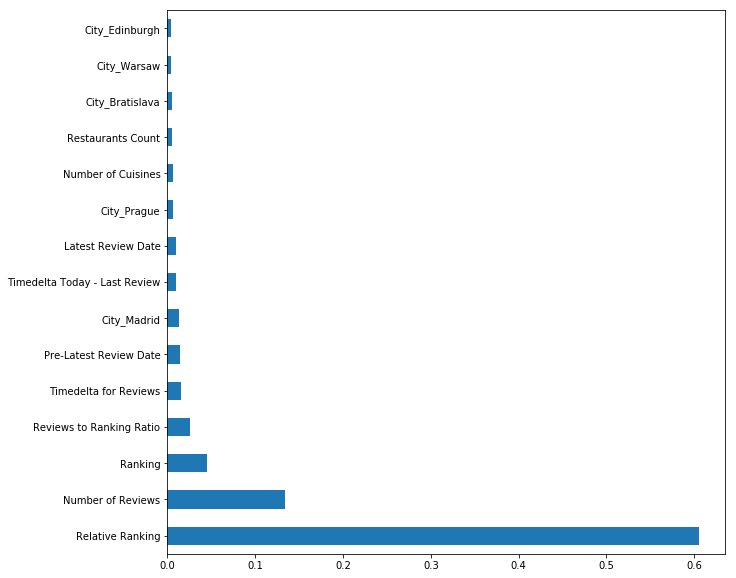

In [424]:
# Evaluating the importance of variables for the forecast.
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

## 6. Submission

In [425]:
# Checking the data.
test_data.info()
test_data.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Columns: 181 entries, Ranking to Pre-Latest Review Bad
dtypes: float64(9), int64(7), uint8(165)
memory usage: 2.9 MB


,Ranking,Price Range,Number of Reviews,Rating,Restaurants Count,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,...,Latest Review Date NAN,Pre-Latest Review Date NAN,Timedelta for Reviews,Timedelta Today - Last Review,Latest Review Content NAN,Pre-Latest Review Content NAN,Latest Review Good,Pre-Latest Review Good,Latest Review Bad,Pre-Latest Review Bad
2296,12756.0,1,8.0,0.0,17593,0,0,0,0,0,...,0,1,1.348272e+09,2.503872e+08,0,0,0,0,1,1
6194,1140.0,2,42.0,0.0,2814,0,1,0,0,0,...,0,0,1.036800e+06,9.443520e+07,0,0,0,1,0,0
2735,3202.0,2,40.0,0.0,10086,0,0,1,0,0,...,0,0,1.166400e+07,1.086912e+08,0,0,1,1,0,0
2037,49.0,2,280.0,0.0,3367,0,0,0,0,0,...,0,0,9.936000e+06,8.553600e+07,0,0,0,1,0,0
3030,1451.0,2,2.0,0.0,1901,0,0,0,0,0,...,1,1,0.000000e+00,1.598659e+09,1,1,0,0,0,0
6017,23.0,2,1182.0,0.0,647,0,0,0,0,0,...,0,0,6.912000e+05,8.320320e+07,0,0,0,0,0,0
1266,4876.0,2,19.0,0.0,8110,0,0,0,1,0,...,0,0,8.812800e+06,1.733184e+08,0,0,0,0,0,0
5688,1411.0,2,44.0,0.0,2637,0,0,0,0,0,...,0,0,5.235840e+07,1.101600e+08,0,0,0,0,0,0
5690,870.0,2,1272.0,0.0,22366,0,0,0,0,0,...,0,0,1.728000e+05,8.346240e+07,0,0,0,0,0,0
9913,4005.0,2,31.0,0.0,17593,0,0,0,0,0,...,0,0,-8.640000e+04,8.519040e+07,0,0,1,1,0,0


In [426]:
# Dropping Rating column.
test_data = test_data.drop(['Rating'], axis=1)

In [427]:
# Checking the data.
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [428]:
# Predicting the rating in a test sample.
predict_submission = np.array([rating_correction(x) for x in model.predict(test_data)])

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [429]:
# Checking the data.
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4.5, 4.5])

In [430]:
# Result submission.
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.sample(10)

,Restaurant_id,Rating
2075,id_2075,4.0
9697,id_9697,4.0
139,id_139,5.0
7276,id_7276,4.0
4764,id_4764,4.5
6893,id_6893,5.0
9232,id_9232,3.5
3669,id_3669,3.5
3882,id_3882,3.5
7772,id_7772,4.5


## 7. Recap & Conclusions 

Let's follow the actions taken:
* We initialized necessary libraries, set visualization conditions and loaded the dataset.
* We analyzed the features, identified the target variable, looked at external sources, and suggested which features we can rely on for feature engineering.
* We checked each variable, filled the NANs, checked the frequency distributions and created several new features.
* We removed the string columns, normalized the data, and wrapped all the code in a single function.
* After a few iterations, we were able to reduce the MAE from the original value of 0.21 to 0.1535.

The most valuable agents for reducing MAE:
* Relative rank feature;
* Rating correction function;
* Timedelta features;
* Reviews to ranking ratio;
* Dummy variables for city.